In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import os
import timm  # For pretrained models


c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
dataset_path = r'D:\university\FER\fer_ckplus_kdef'
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')
test_dir = os.path.join(dataset_path, 'test')

# Data augmentations to reduce overfitting
transform_train = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(112, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_test = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform_test)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")


Train size: 23650, Validation size: 2631, Test size: 6573


In [4]:
class CNNTransFERNet(nn.Module):
    def __init__(self, num_classes):
        super(CNNTransFERNet, self).__init__()

        # Pretrained CNN Backbone (EfficientNet)
        self.cnn = timm.create_model('efficientnet_b0', pretrained=True)
        self.cnn.classifier = nn.Identity()  # Remove the final classification layer

        # Transformer encoder
        self.transformer = nn.TransformerEncoderLayer(d_model=1280, nhead=8)

        # Fully connected layers with dropout and batch normalization
        self.fc1 = nn.Linear(1280, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.cnn(x)  # Extract features (batch_size, 1280)

        # Add sequence dimension for transformer input (batch_size, 1, 1280)
        x = x.unsqueeze(1)
        x = self.transformer(x)
        x = x.squeeze(1)

        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        return x

# Initialize model
num_classes = len(train_dataset.classes)
model = CNNTransFERNet(num_classes=num_classes).to(device)
print(model)


CNNTransFERNet(
  (cnn): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Con

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization added
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [6]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stopping triggered.")


In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, patience=5):
    early_stopping = EarlyStopping(patience=patience, min_delta=0.001)

    train_loss_history, val_loss_history, train_acc_history, val_acc_history = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total

        val_loss, val_acc = evaluate_model(model, val_loader, criterion)

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        scheduler.step()

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Stopping early due to no improvement.")
            break

    # Plot training curves
    plot_metrics(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history


In [8]:
def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_loss / len(loader.dataset)
    val_acc = correct / total

    # Generate confusion matrix and classification report
    plot_confusion_matrix(all_labels, all_preds, train_dataset.classes)
    print_classification_report(all_labels, all_preds, train_dataset.classes)

    return val_loss, val_acc


In [9]:
def plot_metrics(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(12, 5))

    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [10]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


In [11]:
def print_classification_report(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("Classification Report:\n", report)


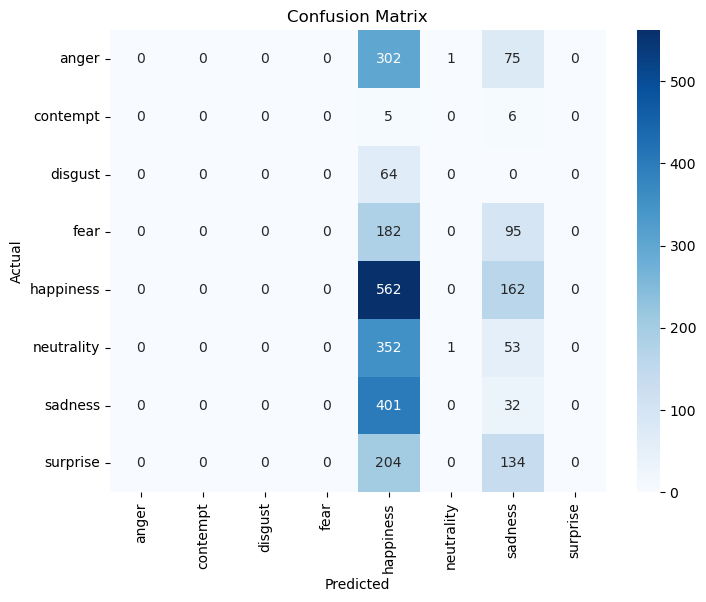

c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00       378
    contempt       0.00      0.00      0.00        11
     disgust       0.00      0.00      0.00        64
        fear       0.00      0.00      0.00       277
   happiness       0.27      0.78      0.40       724
  neutrality       0.50      0.00      0.00       406
     sadness       0.06      0.07      0.06       433
    surprise       0.00      0.00      0.00       338

    accuracy                           0.23      2631
   macro avg       0.10      0.11      0.06      2631
weighted avg       0.16      0.23      0.12      2631

Epoch 1/50 | Train Loss: 1.8974 | Train Acc: 0.2556 | Val Loss: 1.9819 | Val Acc: 0.2261


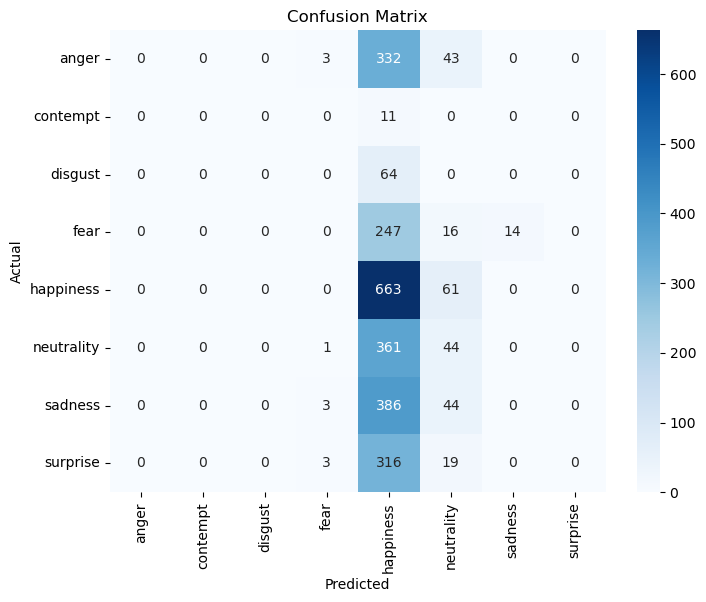

c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00       378
    contempt       0.00      0.00      0.00        11
     disgust       0.00      0.00      0.00        64
        fear       0.00      0.00      0.00       277
   happiness       0.28      0.92      0.43       724
  neutrality       0.19      0.11      0.14       406
     sadness       0.00      0.00      0.00       433
    surprise       0.00      0.00      0.00       338

    accuracy                           0.27      2631
   macro avg       0.06      0.13      0.07      2631
weighted avg       0.11      0.27      0.14      2631

Epoch 2/50 | Train Loss: 1.9015 | Train Acc: 0.2604 | Val Loss: 1.8953 | Val Acc: 0.2687


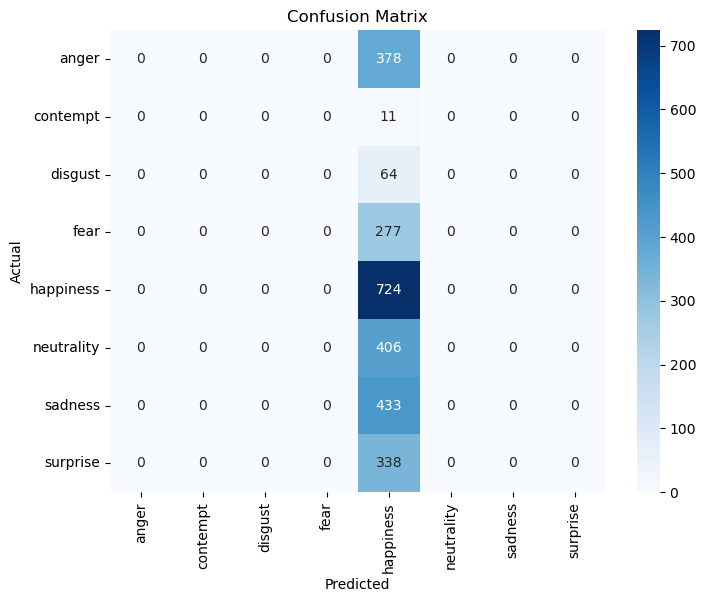

c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00       378
    contempt       0.00      0.00      0.00        11
     disgust       0.00      0.00      0.00        64
        fear       0.00      0.00      0.00       277
   happiness       0.28      1.00      0.43       724
  neutrality       0.00      0.00      0.00       406
     sadness       0.00      0.00      0.00       433
    surprise       0.00      0.00      0.00       338

    accuracy                           0.28      2631
   macro avg       0.03      0.12      0.05      2631
weighted avg       0.08      0.28      0.12      2631

Epoch 3/50 | Train Loss: 1.8774 | Train Acc: 0.2619 | Val Loss: 1.8233 | Val Acc: 0.2752


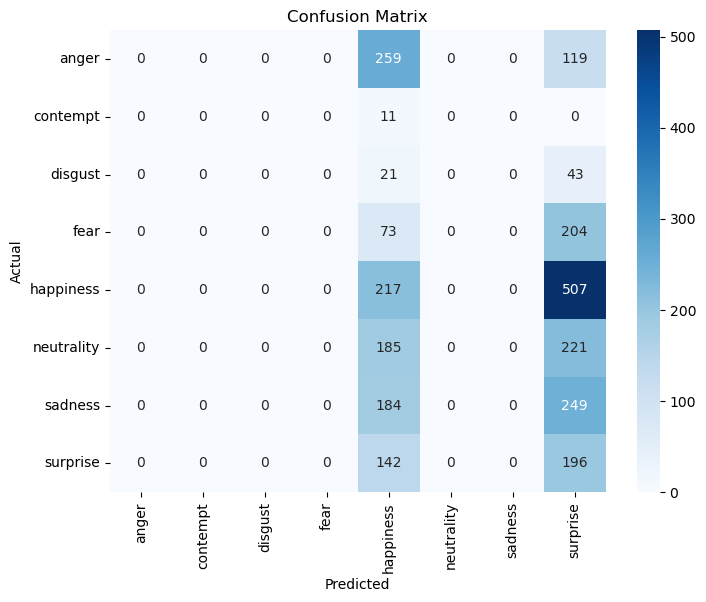

c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00       378
    contempt       0.00      0.00      0.00        11
     disgust       0.00      0.00      0.00        64
        fear       0.00      0.00      0.00       277
   happiness       0.20      0.30      0.24       724
  neutrality       0.00      0.00      0.00       406
     sadness       0.00      0.00      0.00       433
    surprise       0.13      0.58      0.21       338

    accuracy                           0.16      2631
   macro avg       0.04      0.11      0.06      2631
weighted avg       0.07      0.16      0.09      2631

Epoch 4/50 | Train Loss: 1.8629 | Train Acc: 0.2669 | Val Loss: 1.8788 | Val Acc: 0.1570


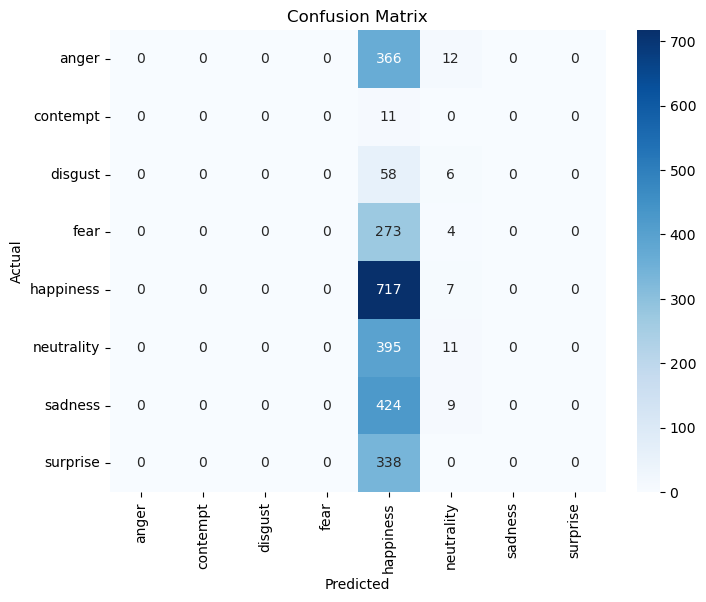

c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00       378
    contempt       0.00      0.00      0.00        11
     disgust       0.00      0.00      0.00        64
        fear       0.00      0.00      0.00       277
   happiness       0.28      0.99      0.43       724
  neutrality       0.22      0.03      0.05       406
     sadness       0.00      0.00      0.00       433
    surprise       0.00      0.00      0.00       338

    accuracy                           0.28      2631
   macro avg       0.06      0.13      0.06      2631
weighted avg       0.11      0.28      0.13      2631

Epoch 5/50 | Train Loss: 1.8529 | Train Acc: 0.2684 | Val Loss: 1.8844 | Val Acc: 0.2767


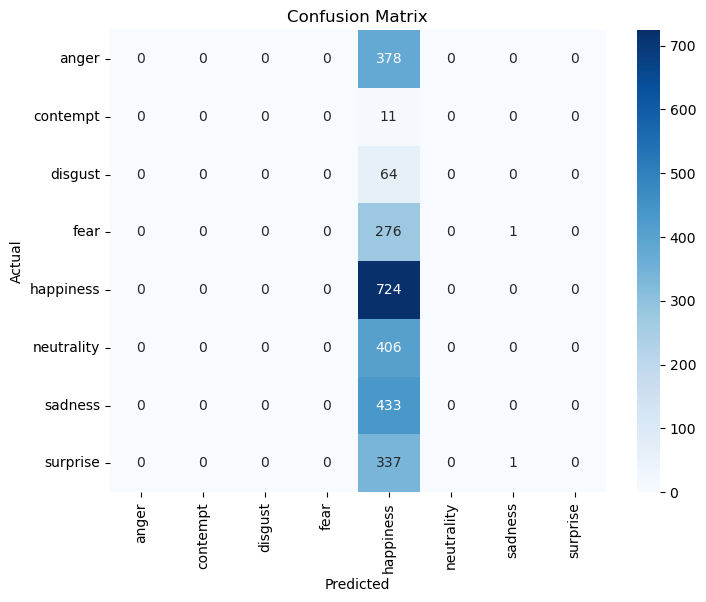

c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00       378
    contempt       0.00      0.00      0.00        11
     disgust       0.00      0.00      0.00        64
        fear       0.00      0.00      0.00       277
   happiness       0.28      1.00      0.43       724
  neutrality       0.00      0.00      0.00       406
     sadness       0.00      0.00      0.00       433
    surprise       0.00      0.00      0.00       338

    accuracy                           0.28      2631
   macro avg       0.03      0.12      0.05      2631
weighted avg       0.08      0.28      0.12      2631

Epoch 6/50 | Train Loss: 1.8403 | Train Acc: 0.2732 | Val Loss: 1.8404 | Val Acc: 0.2752


KeyboardInterrupt: 

In [12]:
num_epochs = 50
train_loss, val_loss, train_acc, val_acc = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience=5
)
